In [16]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv('data/umist_cropped_with_cluster_id_training.csv')
val_data = pd.read_csv(r'data\validation_data\umist_cropped_with_cluster_id_val.csv')
test_data = pd.read_csv('data/test_data/umist_cropped_with_cluster_id_test.csv')

In [18]:
X_train = data.drop(['cluster_id'],axis = 1)
y_train = data['cluster_id']

X_val = val_data.drop(['cluster_id'],axis = 1)
y_val = val_data['cluster_id']

X_test = test_data.drop(['cluster_id'],axis = 1)
y_test = test_data['cluster_id']

In [40]:
print(type(X_train))

<class 'numpy.ndarray'>


In [21]:
# Extract pixel values and reshape
X_train = X_train.values.reshape(-1, 112, 92, 1)

X_val = X_val.values.reshape(-1, 112, 92, 1)

X_test = X_test.values.reshape(-1, 112, 92, 1)

In [23]:
# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [25]:
IMAGE_WIDTH = 112
IMAGE_HEIGHT = 92
NUM_CLASSES = np.unique(y_train).shape[0]
BATCH_SIZE = 32
EPOCHS = 20
NUMBER_OF_TRAINING_IMAGES = 600

In [26]:
model = models.Sequential()

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

model.add(Dropout(0.5))

model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 92, 512)        │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 46, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 54, 44, 128)         │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 27, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 20, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,932,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,613,848 (17.60 MB)

 Trainable params: 4,613,848 (17.60 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto',
)

model_checkpoint = ModelCheckpoint(
    filepath='models/classifier/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
)


In [29]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

In [30]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0479 - loss: 14.2021
Epoch 1: val_accuracy improved from -inf to 0.07965, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.0488 - loss: 14.1363 - val_accuracy: 0.0796 - val_loss: 10.0950
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0840 - loss: 9.2217
Epoch 2: val_accuracy improved from 0.07965 to 0.25664, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0861 - loss: 9.1805 - val_accuracy: 0.2566 - val_loss: 6.4308
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2537 - loss: 6.0224
Epoch 3: val_accuracy improved from 0.25664 to 0.52212, saving model to models/classifier/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2554 - loss: 5.9953 - val_accuracy: 0.5221 - val_loss: 4.2240
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5095 - loss: 3.9354
Ep

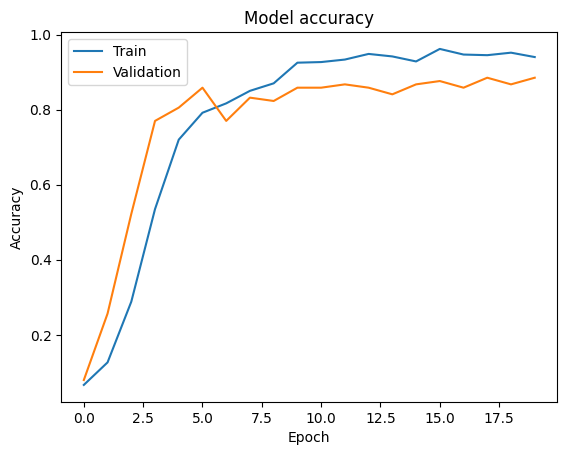

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

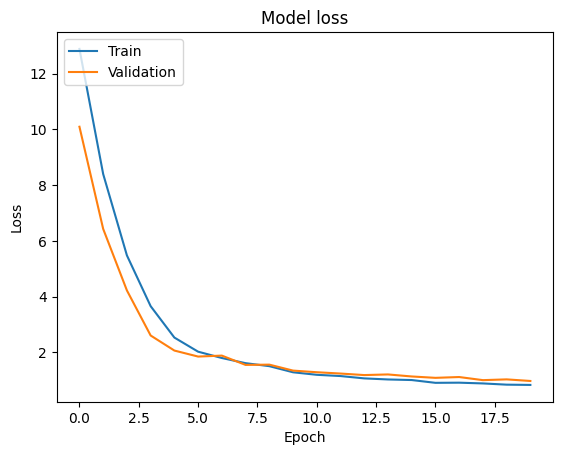

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
best_model = models.load_model('models/classifier/best_model.keras')

In [34]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - accuracy: 0.9277 - loss: 1.0433
Test loss: 1.124246597290039
Test accuracy: 0.9026548862457275


In [35]:
y_test_pred = best_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 561ms/step


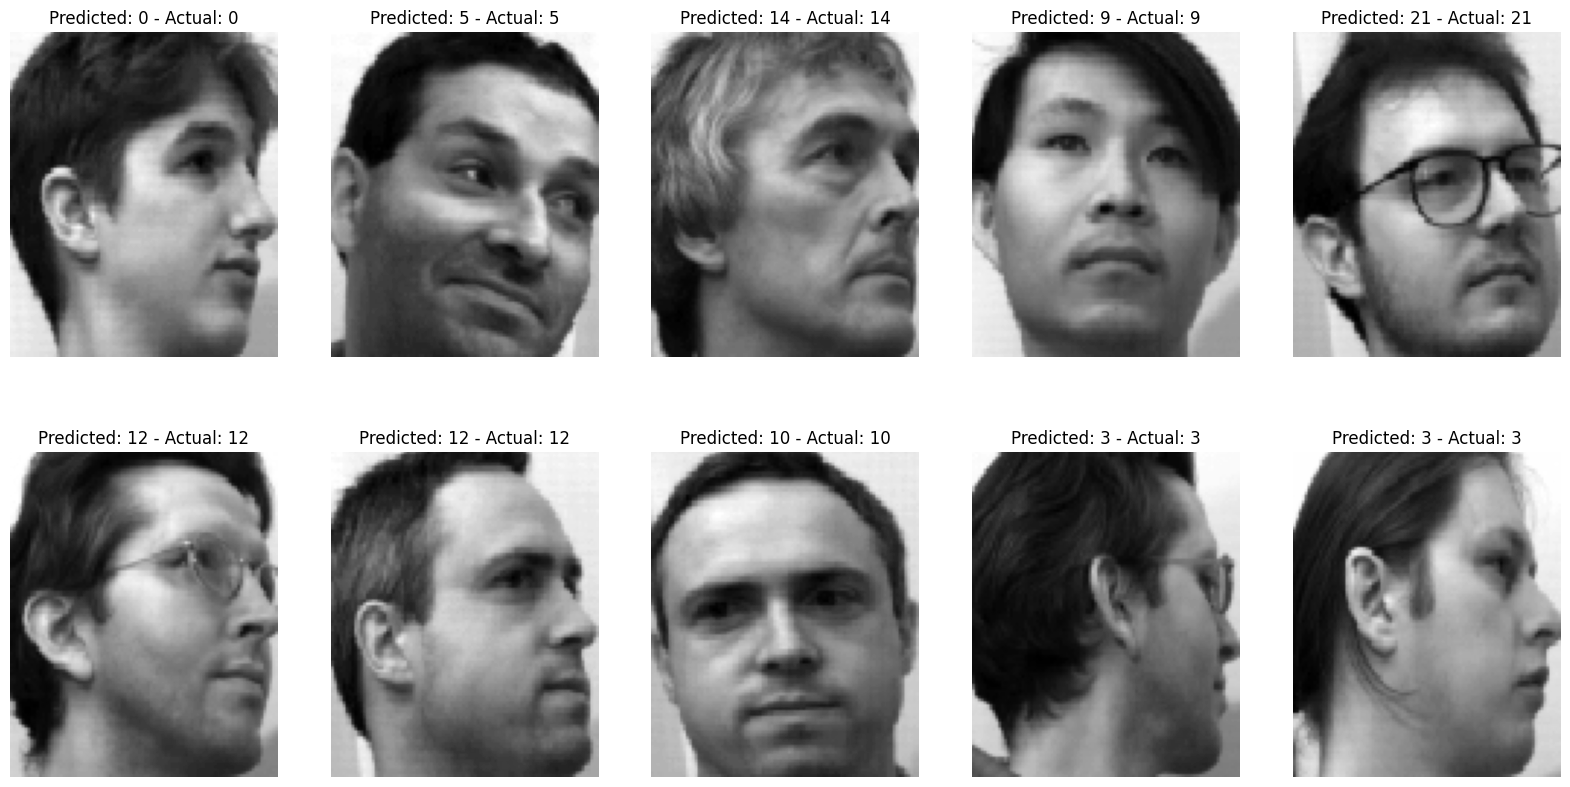

In [39]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i in range(10):
    ax[i // 5, i % 5].imshow(X_test[i].reshape(112, 92), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Predicted: {np.argmax(y_test_pred[i])} - Actual: {y_test[i]}")
    ax[i // 5, i % 5].axis('off')

plt.show()